In [1]:
# Setup

import numpy as np
import pandas as pd
import sklearn.metrics as skm
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import anndata
import os

print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

NumPy version: 2.0.2
Pandas version: 2.3.3


In [2]:
# Set your working directory
os.chdir("..")  

# Verify current directory
print(f"Current working directory: {os.getcwd()}")

Current working directory: /Users/tardis/Library/CloudStorage/GoogleDrive-natrdn@gmail.com/My Drive/Natália (Academic Folder)/Post_doc/ML_pred_scRNA


In [3]:
# Load data (Same as Day 1)
data = anndata.read_h5ad("data/my_dataset_small.h5ad")

print("=" * 60)
print("DATA LOADING")
print("=" * 60)
print(f"Original data shape: {data.shape}")
print(f"Cells: {data.n_obs}, Genes: {data.n_vars}")

DATA LOADING
Original data shape: (2988, 33159)
Cells: 2988, Genes: 33159


In [4]:
# Normalize data (Same as day 1)
from scipy import sparse

print("\n" + "=" * 60)
print("NORMALIZATION")
print("=" * 60)

X = data.X

# Ensure CSR format
if not sparse.isspmatrix_csr(X):
    X = X.tocsr()

# 1. Sum per cell
cell_sums = np.array(X.sum(axis=1)).flatten()
cell_sums[cell_sums == 0] = 1.0

# 2. Normalize by total counts
X = X.multiply(1.0 / cell_sums[:, None])

# 3. Multiply by 1e6
X = X.multiply(1e6)

# 4. Log1p transform
X = X.log1p()

# 5. Back to CSR
X = X.tocsr()

data.X = X

print("Finished normalization and log transformation.")


NORMALIZATION
Finished normalization and log transformation.


In [5]:
# Filter lowly expressed genes (Modified cutoff)
print("\n" + "=" * 60)
print("GENE FILTERING (cutoff=0.5)")
print("=" * 60)

# Instructions5: Filter genes expressed in > 50% of cells (cutoff 0.5)
gene_filter = data.X.sum(axis=0) > data.shape[0] * 0.5
gene_filter = np.asarray(gene_filter).flatten()

print(f"Original number of genes: {data.n_vars}")
data = data[:, gene_filter].copy()
print(f"After filtering (>50% cells): {data.n_vars} genes")


GENE FILTERING (cutoff=0.5)
Original number of genes: 33159
After filtering (>50% cells): 8214 genes


In [6]:
# Filter to astrocytes and glioblasts
print("\n" + "=" * 60)
print("CELL TYPE FILTERING")
print("=" * 60)

# Filter to only Astrocytes and Glioblasts
data = data[data.obs.author_cell_type.apply(lambda x: x in ["Astrocytes", "Glioblasts"])].copy()

print(f"Filtered data shape: {data.shape}")
print(f"\nCell type distribution:")
print(data.obs.author_cell_type.value_counts())


CELL TYPE FILTERING
Filtered data shape: (440, 8214)

Cell type distribution:
author_cell_type
Astrocytes    264
Glioblasts    176
Name: count, dtype: int64


In [7]:
# Setup data and tensors (X and Y)
print("\n" + "=" * 60)
print("SETUP X AND Y")
print("=" * 60)

# Input X: gene expression (keep as sparse for now)
X = data.X

print(f"X shape: {X.shape}")
print(f"X type: {type(X)}")

# Output Y: binary labels (Astrocytes vs Glioblasts)
Y = data.obs["author_cell_type"].tolist()

print(f"Number of labels: {len(Y)}")
print(f"Example labels: {Y[:10]}")
print(f"Unique labels: {pd.Series(Y).unique().tolist()}")


SETUP X AND Y
X shape: (440, 8214)
X type: <class 'scipy.sparse._csr.csr_matrix'>
Number of labels: 440
Example labels: ['Astrocytes', 'Astrocytes', 'Astrocytes', 'Astrocytes', 'Astrocytes', 'Astrocytes', 'Astrocytes', 'Astrocytes', 'Astrocytes', 'Astrocytes']
Unique labels: ['Astrocytes', 'Glioblasts']


In [8]:
### Define Model
print("\n" + "=" * 60)
print("MODEL DEFINITION")
print("=" * 60)

# Random Forest with 10 estimators (trees)
model = RandomForestClassifier(
    n_estimators=10,
    random_state=42,
    n_jobs=-1  # use all CPU cores
)

print("Defined RandomForestClassifier:")
print(f"  n_estimators: 10")
print(f"  random_state: 42")
print(model)


MODEL DEFINITION
Defined RandomForestClassifier:
  n_estimators: 10
  random_state: 42
RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)


In [9]:
# Train-Test split
# here the best practice would be to split the data in train and test BEFORE normalizing- to avoid data leakage
print("\n" + "=" * 60)
print("TRAIN-TEST SPLIT")
print("=" * 60)

# Split data (25% test)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y
)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"Y_train size:  {len(Y_train)}")
print(f"Y_test size:   {len(Y_test)}")


TRAIN-TEST SPLIT
X_train shape: (330, 8214)
X_test shape:  (110, 8214)
Y_train size:  330
Y_test size:   110


In [10]:
# Train the model
print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)

# Fit Random Forest on training data
model.fit(X_train, Y_train)

print("✓ Model trained successfully.")


TRAINING
✓ Model trained successfully.


In [11]:
# Evaluate accuracy on test data
print("\n" + "=" * 60)
print("TEST ACCURACY")
print("=" * 60)

# Predict on test data
Y_test_pred = model.predict(X_test)

# Calculate accuracy
test_accuracy = skm.accuracy_score(Y_test, Y_test_pred)

print(f"Test accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Also show confusion matrix
print("\nConfusion matrix:")
print(pd.crosstab(Y_test, Y_test_pred, rownames=['Actual'], colnames=['Predicted']))


TEST ACCURACY
Test accuracy: 0.8818 (88.18%)

Confusion matrix:
Predicted   Astrocytes  Glioblasts
Actual                            
Astrocytes          62           4
Glioblasts           9          35


In [12]:
### Feature Importance
# Permutation Feature Importance
print("\n" + "=" * 60)
print("PERMUTATION FEATURE IMPORTANCE")
print("=" * 60)

# Convert test data to dense numpy array (required by permutation_importance)
X_test_dense = np.asarray(X_test.todense())

print(f"X_test_dense shape: {X_test_dense.shape}")
print(f"X_test_dense type: {type(X_test_dense)}")

# Calculate permutation importance
# - n_repeats=5: shuffle each feature 5 times
# - random_state for reproducibility
feature_importance = permutation_importance(
    model, X_test_dense, Y_test,
    n_repeats=5,
    random_state=42,
    n_jobs=-1
)

print("\n✓ Permutation importance calculated.")
print(f"Type: {type(feature_importance)}")
print(f"Keys: {feature_importance.keys() if hasattr(feature_importance, 'keys') else 'N/A'}")


PERMUTATION FEATURE IMPORTANCE
X_test_dense shape: (110, 8214)
X_test_dense type: <class 'numpy.ndarray'>

✓ Permutation importance calculated.
Type: <class 'sklearn.utils._bunch.Bunch'>
Keys: dict_keys(['importances_mean', 'importances_std', 'importances'])


In [13]:
# Explore feature imporance object
print("\n" + "=" * 60)
print("FEATURE IMPORTANCE STRUCTURE")
print("=" * 60)

print("feature_importance contains:")
print(f"  - importances_mean: shape {feature_importance.importances_mean.shape}")
print(f"  - importances_std:  shape {feature_importance.importances_std.shape}")
print(f"  - importances:      shape {feature_importance.importances.shape}")

print(f"\nFirst 10 mean importances:")
print(feature_importance.importances_mean[:10])


FEATURE IMPORTANCE STRUCTURE
feature_importance contains:
  - importances_mean: shape (8214,)
  - importances_std:  shape (8214,)
  - importances:      shape (8214, 5)

First 10 mean importances:
[0.         0.         0.         0.         0.00181818 0.
 0.         0.         0.         0.        ]



HISTOGRAM OF FEATURE IMPORTANCES


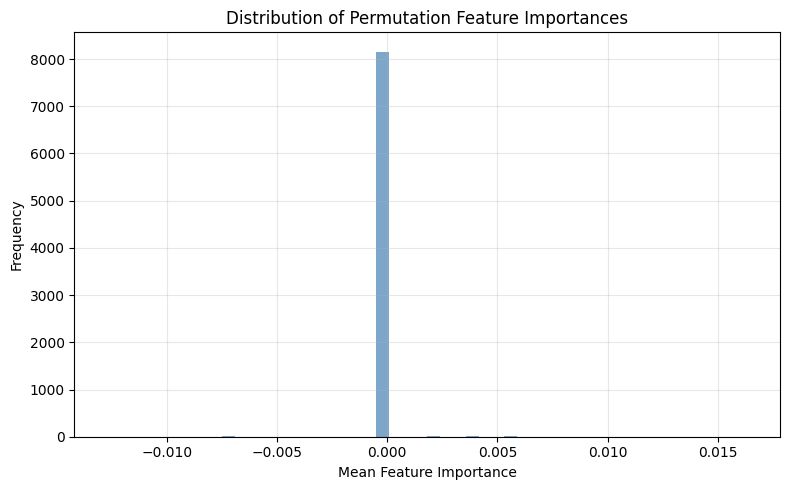

✓ Histogram saved as 'day5_feature_importance_histogram.png'

Summary statistics:
  Mean: 0.000013
  Std:  0.000558
  Min:  -0.012727
  Max:  0.016364


In [22]:
# Explore feature importance values
# histogram of mean feature importances
print("\n" + "=" * 60)
print("HISTOGRAM OF FEATURE IMPORTANCES")
print("=" * 60)

plt.figure(figsize=(8, 5))
plt.hist(feature_importance.importances_mean, bins=50, color='steelblue', alpha=0.7)
plt.xlabel('Mean Feature Importance')
plt.ylabel('Frequency')
plt.title('Distribution of Permutation Feature Importances')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('day5_feature_importance_histogram.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Histogram saved as 'day5_feature_importance_histogram.png'")

# Summary statistics
print(f"\nSummary statistics:")
print(f"  Mean: {feature_importance.importances_mean.mean():.6f}")
print(f"  Std:  {feature_importance.importances_mean.std():.6f}")
print(f"  Min:  {feature_importance.importances_mean.min():.6f}")
print(f"  Max:  {feature_importance.importances_mean.max():.6f}")

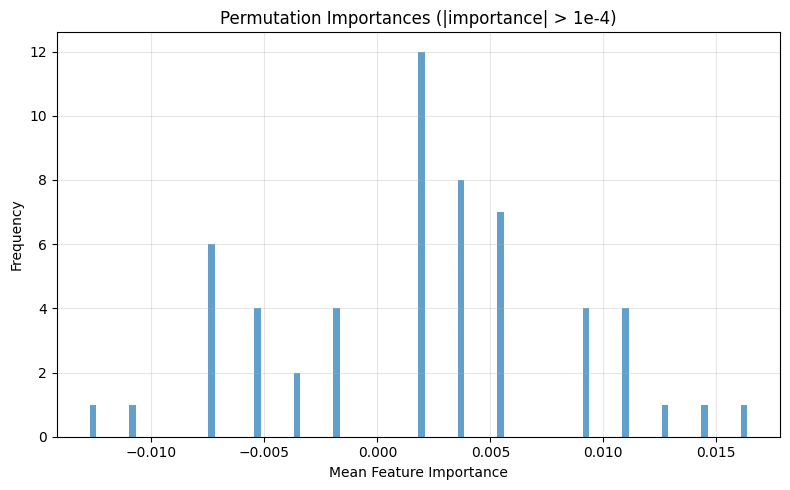

Kept 56 / 8214 features


In [23]:
# What do the non-null features look like?
# Exclude the near-zero bulk and zoom
import numpy as np

vals = feature_importance.importances_mean

# keep values away from zero
mask = np.abs(vals) > 1e-4
vals_zoom = vals[mask]

plt.figure(figsize=(8, 5))
plt.hist(vals_zoom, bins=100, alpha=0.7)
plt.xlabel("Mean Feature Importance")
plt.ylabel("Frequency")
plt.title("Permutation Importances (|importance| > 1e-4)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Kept {len(vals_zoom)} / {len(vals)} features")

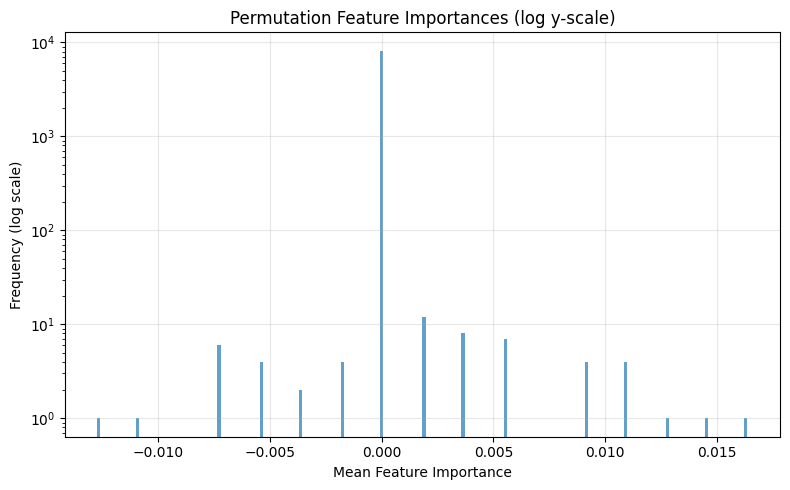

In [24]:
# How dominant is the null mass compared to signal ?
#  Log-scale the y-axis (shows both spike + tail)

plt.figure(figsize=(8, 5))
plt.hist(vals, bins=200, alpha=0.7)
plt.yscale("log")
plt.xlabel("Mean Feature Importance")
plt.ylabel("Frequency (log scale)")
plt.title("Permutation Feature Importances (log y-scale)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

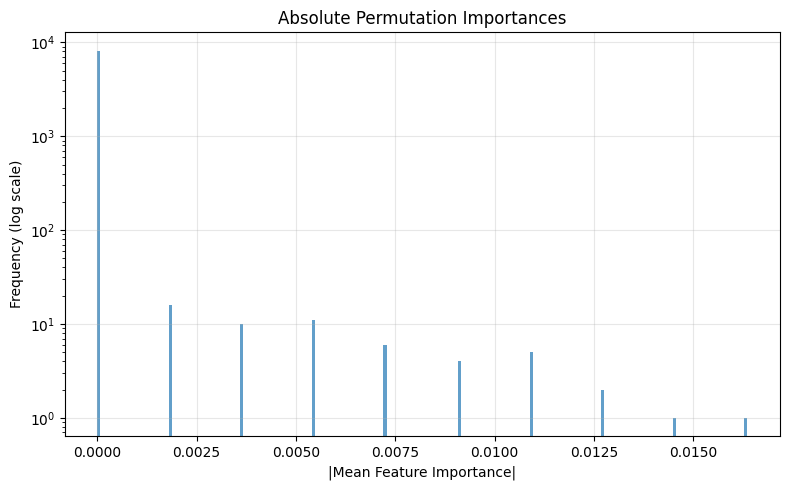

In [25]:
# Plot absolute importance
plt.figure(figsize=(8, 5))
plt.hist(np.abs(vals), bins=200, alpha=0.7)
plt.yscale("log")
plt.xlabel("|Mean Feature Importance|")
plt.ylabel("Frequency (log scale)")
plt.title("Absolute Permutation Importances")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [26]:
# Data of most important feature
# Identify top 10 features
print("\n" + "=" * 60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("=" * 60)

# 1. Absolute value of mean importances
abs_importance = np.abs(feature_importance.importances_mean)

# 2. Sort indices (ascending order)
idx = np.argsort(abs_importance, axis=0)

print(f"idx shape: {idx.shape}")
print(f"idx type: {type(idx)}")

# 3. Get indices of top 10 features (last 10 values)
i = idx[-10:]

print(f"\nTop 10 feature indices: {i}")

# 4. Mean importances of these features
print(f"\nMean importances of top 10 features:")
for rank, feature_idx in enumerate(i[::-1], 1):  # reverse to show highest first
    print(f"  Rank {rank}: Feature {feature_idx}, Importance {feature_importance.importances_mean[feature_idx]:.6f}")


TOP 10 MOST IMPORTANT FEATURES
idx shape: (8214,)
idx type: <class 'numpy.ndarray'>

Top 10 feature indices: [4260  473 7574 4674 4382 5016 4056 4083 5367 4870]

Mean importances of top 10 features:
  Rank 1: Feature 4870, Importance 0.016364
  Rank 2: Feature 5367, Importance 0.014545
  Rank 3: Feature 4083, Importance 0.012727
  Rank 4: Feature 4056, Importance -0.012727
  Rank 5: Feature 5016, Importance 0.010909
  Rank 6: Feature 4382, Importance 0.010909
  Rank 7: Feature 4674, Importance 0.010909
  Rank 8: Feature 7574, Importance 0.010909
  Rank 9: Feature 473, Importance -0.010909
  Rank 10: Feature 4260, Importance 0.009091


In [27]:
# Gene information of top features
print("\n" + "=" * 60)
print("GENE INFORMATION (Top 10)")
print("=" * 60)

# 5. Look at gene information
top_genes = data.var.iloc[i]
print(top_genes)


GENE INFORMATION (Top 10)
                Chromosome       End          Gene     Start Strand  \
Accession                                                             
ENSG00000050165         11  12009769          DKK3  11963106      -   
ENSG00000179915          2  51225575         NRXN1  49918505      -   
ENSG00000099901         22  20127357        RANBP1  20115938      +   
ENSG00000247828          5  88436685  TMEM161B-AS1  88268895      +   
ENSG00000026025         10  17237593           VIM  17228259      +   
ENSG00000168078          8  27838095           PBK  27809620      -   
ENSG00000187134         10   4983283        AKR1C1   4963253      +   
ENSG00000100505         14  51096061         TRIM9  50975262      -   
ENSG00000116560          1  35193148          SFPQ  35176378      -   
ENSG00000071655         19   1592801          MBD3   1573596      -   

                 feature_is_filtered feature_name feature_reference  \
Accession                                        

In [28]:
# Extract Expression Data of Top Gene
print("\n" + "=" * 60)
print("EXPRESSION DATA OF TOP GENE")
print("=" * 60)

# 6. Get expression values of the top gene (last element of i)
top_gene_idx = i[-1]
data_f1 = data.X[:, top_gene_idx]

# 7. Look at shape
print(f"data_f1 shape: {data_f1.shape}")
print(f"data_f1 type: {type(data_f1)}")

# 8. Convert to 1-D numpy array
data_f1 = np.asarray(data_f1.todense())[:, 0]

print(f"\nAfter conversion:")
print(f"  shape: {data_f1.shape}")
print(f"  type: {type(data_f1)}")
print(f"  First 10 values: {data_f1[:10]}")


EXPRESSION DATA OF TOP GENE
data_f1 shape: (440, 1)
data_f1 type: <class 'scipy.sparse._csr.csr_matrix'>

After conversion:
  shape: (440,)
  type: <class 'numpy.ndarray'>
  First 10 values: [0.        4.4553313 0.        0.        5.5025616 4.0190425 4.6148233
 4.5152407 0.        0.       ]



BOXPLOT: TOP GENE EXPRESSION BY CELL TYPE
Astrocyte expression: 264 cells
Glioblast expression: 176 cells


/var/folders/m0/tl6mfs_n4cv8x4x4hmktr2h00000gn/T/ipykernel_4736/621152184.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(expr_by_celltype, labels=['Astrocytes', 'Glioblasts'])


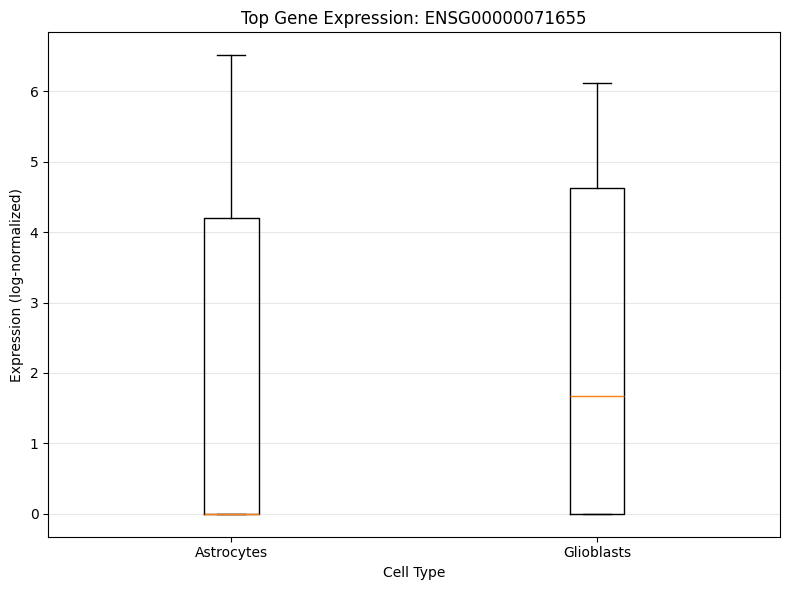


✓ Boxplot saved as 'day5_top_gene_boxplot.png'
Top gene: ENSG00000071655
  Astrocytes - mean: 1.3075, std: 2.1118
  Glioblasts - mean: 2.3551, std: 2.3914


In [29]:
# Separate by Cell Type and Create Boxplot
print("\n" + "=" * 60)
print("BOXPLOT: TOP GENE EXPRESSION BY CELL TYPE")
print("=" * 60)

# 9. Create boolean vectors for each cell type
is_astrocyte = data.obs.author_cell_type == "Astrocytes"
is_glioblast = data.obs.author_cell_type == "Glioblasts"

# Extract expression for each cell type
astrocyte_expr = data_f1[is_astrocyte]
glioblast_expr = data_f1[is_glioblast]

print(f"Astrocyte expression: {len(astrocyte_expr)} cells")
print(f"Glioblast expression: {len(glioblast_expr)} cells")

# Combine in a list for boxplot
expr_by_celltype = [astrocyte_expr, glioblast_expr]

# 10. Create boxplot
plt.figure(figsize=(8, 6))
plt.boxplot(expr_by_celltype, labels=['Astrocytes', 'Glioblasts'])
plt.ylabel('Expression (log-normalized)')
plt.xlabel('Cell Type')
plt.title(f'Top Gene Expression: {data.var_names[top_gene_idx]}')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('day5_top_gene_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Boxplot saved as 'day5_top_gene_boxplot.png'")
print(f"Top gene: {data.var_names[top_gene_idx]}")
print(f"  Astrocytes - mean: {astrocyte_expr.mean():.4f}, std: {astrocyte_expr.std():.4f}")
print(f"  Glioblasts - mean: {glioblast_expr.mean():.4f}, std: {glioblast_expr.std():.4f}")